# NonSaturating MinMaxGANs Implementation
                                                        - K.Krishna Dhakshin

##Import Essential Stuff

In [0]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Loading DataSets (CIFAR10/MNIST)

In [0]:
bool = False  #set to true for CIFAR10 and false for MNIST

In [0]:
if bool:
  trainset = dset.CIFAR10(root='./cifar10', train=True, transform=transforms.Compose([transforms.Resize((32, 32)),  transforms.ToTensor(), transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))]), download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
  nc = 3
else:
  trainset = dset.MNIST(root='./mnist', train=True, transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std = (0.5,))]), download=True)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
  nc = 1

0it [00:00, ?it/s]

9920512it [00:01, 8320803.66it/s]                            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134260.73it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2201975.04it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50020.22it/s]            


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


##Visualizing DataSet

In [0]:
len(trainset)

60000

In [0]:
len(trainloader)

600

In [0]:
batch = next(iter(trainloader))
vutils.make_grid(batch[0]).size()

torch.Size([3, 444, 274])

In [0]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

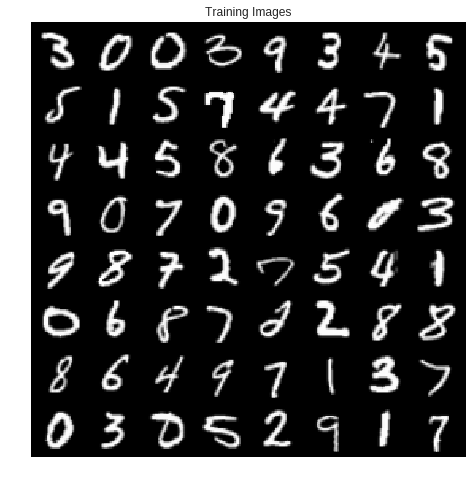

In [0]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

100

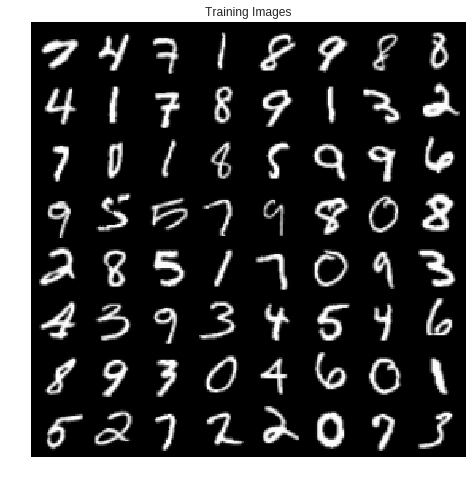

In [0]:
batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
batch[0].size(0)

## Designing the GANs Model

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [0]:
netG = Generator()
netG.cuda()

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [0]:
netD = Discriminator()
netD.cuda()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Dropout2d(p=0.3)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Dropout2d(p=0.3)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): Dropout2d(p=0.3)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [0]:
netG.apply(weights_init)
print(netG)
netD.apply(weights_init)
print(netD)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=

In [0]:
real = 1
fake = 0

In [0]:
criterion = nn.BCELoss()
optimizerD = optim.SGD(netD.parameters(), lr=0.02)
optimizerG = optim.SGD(netG.parameters(), lr=0.02)

In [0]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

In [0]:
device

device(type='cuda', index=0)

##Training Network

In [0]:
img_list = []
G_losses = []
D_losses = []
iters = 0

In [0]:
for epoch in range(100):
  for i, data in enumerate(trainloader, 0):
        netD.zero_grad()
        data[0] = data[0].cuda()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real, device=device)
        output = netD(torch.cuda.FloatTensor(real_cpu)).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fakeim = netG(noise)
        label.fill_(fake)
        output = netD(fakeim.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fakeim = netG(noise)
        label.fill_(real)
        output = netD(torch.cuda.FloatTensor(fakeim)).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print('[%d/10][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        if (iters % 500 == 0) or ((i == len(trainloader)-1)):
            with torch.no_grad():
                fakeim = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakeim, padding=2, normalize=True))
        iters += 1

[0/10][0/600]	Loss_D: 2.0207	Loss_G: 11.0276	D(x): 0.9140	D(G(z)): 0.7988 / 0.0001
[0/10][1/600]	Loss_D: 6.6800	Loss_G: 0.0037	D(x): 0.0037	D(G(z)): 0.0102 / 0.9963
[0/10][2/600]	Loss_D: 6.9480	Loss_G: 12.6980	D(x): 0.9998	D(G(z)): 0.9969 / 0.0001
[0/10][3/600]	Loss_D: 7.2831	Loss_G: 0.6348	D(x): 0.0065	D(G(z)): 0.0001 / 0.6239
[0/10][4/600]	Loss_D: 7.9843	Loss_G: 9.8630	D(x): 0.9992	D(G(z)): 0.9976 / 0.0002
[0/10][5/600]	Loss_D: 6.1876	Loss_G: 0.0159	D(x): 0.0066	D(G(z)): 0.0061 / 0.9847
[0/10][6/600]	Loss_D: 5.2301	Loss_G: 10.5409	D(x): 0.9962	D(G(z)): 0.9900 / 0.0001
[0/10][7/600]	Loss_D: 1.7770	Loss_G: 4.1244	D(x): 0.4055	D(G(z)): 0.0001 / 0.0563
[0/10][8/600]	Loss_D: 0.2165	Loss_G: 4.5708	D(x): 0.9834	D(G(z)): 0.1385 / 0.0193
[0/10][9/600]	Loss_D: 2.5755	Loss_G: 10.0176	D(x): 0.9642	D(G(z)): 0.7669 / 0.0004
[0/10][10/600]	Loss_D: 4.8364	Loss_G: 0.0147	D(x): 0.0925	D(G(z)): 0.1272 / 0.9884
[0/10][11/600]	Loss_D: 8.4134	Loss_G: 16.5990	D(x): 0.9540	D(G(z)): 0.9938 / 0.0000
[0/10][12

KeyboardInterrupt: ignored

## Visualising Generated Samples and Error functions

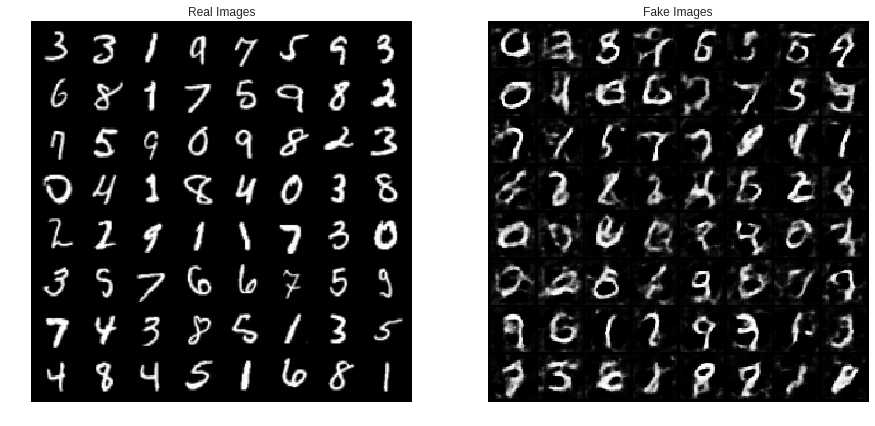

In [0]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

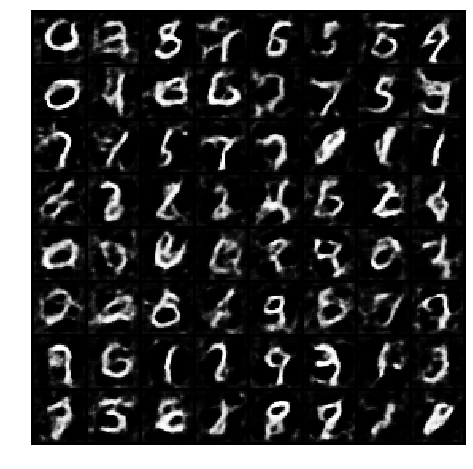

In [0]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

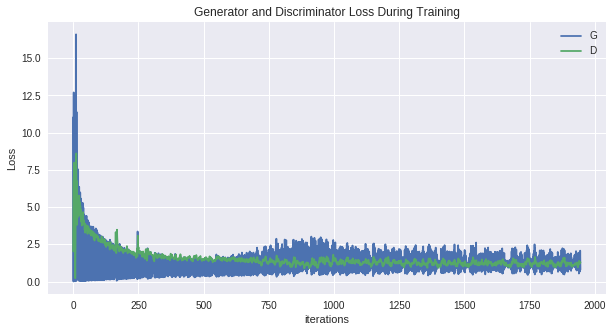

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saving Model and Data in files and Uploading to Drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                 
drive = GoogleDrive(gauth)

In [0]:
def upld_drive(x):  
  model_file = drive.CreateFile({'title' : x})             
  model_file.SetContentFile(x)  
  model_file.Upload()
  drive.CreateFile({'id': model_file.get('id')})

In [0]:
if bool!=True:
  torch.save(netG, 'GenMNIST')
  torch.save(netD, 'DisMNIST')
  torch.save(img_list, 'ImgMNIST')
  torch.save(G_losses, 'GlossMNIST')
  torch.save(D_losses, 'DlossMNIST')
  upld_drive('GenMNIST')
  upld_drive('DisMNIST')
  upld_drive('ImgMNIST')
  upld_drive('GlossMNIST')
  upld_drive('DlossMNIST')

In [0]:
if bool:
  torch.save(netG, 'GenCIFAR10')
  torch.save(netD, 'DisCIFAR10')
  torch.save(img_list, 'ImgCIFAR10')
  torch.save(G_losses, 'GlossCIFAR10')
  torch.save(D_losses, 'DlossCIFAR10')
  upld_drive('GenCIFAR10')
  upld_drive('DisCIFAR10')
  upld_drive('ImgCIFAR10')
  upld_drive('GlossCIFAR10')
  upld_drive('DlossCIFAR10')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
netG=torch.load('GenMNIST')
netD=torch.load('DisMNIST')
img_list=torch.load('ImgMNIST')
G_losses=torch.load('GlossMNIST')
D_losses=torch.load('DlossMNIST')

In [0]:
netG=torch.load('GenCIFAR10')
netD=torch.load('DisCIFAR10')
img_list=torch.load('ImgCIFAR10')
G_losses=torch.load('GlossCIFAR10')
D_losses=torch.load('DlossCIFAR10')